In [216]:
import pandas as pd
from os import chdir
#import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from scipy import stats


In [217]:
categories = ['sad', 'angry', 'energetic', 'excited', 'happy', 'content','calm',  'depressed']

def offByOne(y_test_standard, y_pred,digits=3,returnData = False):
    #compare y_test_standard with y_pred_list. If y_pred_list is +-1 from y_test_standard, then it change it to be the same as y_test_standard
    y_test_standard_list=list(y_test_standard)
    y_pred_list = list(y_pred)
    for id in range(len(y_test_standard_list)):
        if y_test_standard_list[id] != 0 and y_test_standard_list[id] != 7:
            if y_pred_list[id] == y_test_standard_list[id] - 1 or y_pred_list[id] == y_test_standard_list[id] + 1:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 0:
            if y_pred_list[id] ==  1 or y_pred_list[id] == 7:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 7:
            if y_pred_list[id] ==  0 or y_pred_list[id] == 6:
                y_pred_list[id] = y_test_standard_list[id]
    print(classification_report(y_test_standard_list, y_pred_list,digits = digits,target_names=categories))
    result = classification_report(y_test_standard_list, y_pred_list,digits = digits,target_names=categories,output_dict=True)
    #show the result in a dataframe
    if returnData:
        return result
    return

In [218]:
#chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Audio Features/emotion joint data')
emotionsDF = pd.read_csv('Merged Emotions Data4.csv')

In [219]:
#chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v2.1')

In [220]:
#load in the rf2.pkl model
import pickle
with open('rf2.pkl', 'rb') as file:
    rf2 = pickle.load(file)

In [221]:
categories = ['sad', 'angry', 'energetic', 'excited', 'happy', 'content','calm',  'depressed']
emotionsDF['mood'] = pd.Categorical(emotionsDF['mood'], categories=categories, ordered=True)


In [222]:
#make a classifier for the emotionsDF, which only takes in valence and energy, and outputs the mood

"""
X = emotionsDF[['valence','energy']]
y = emotionsDF['mood']
"""
#only take an even number of each mood
# create a new df with only up to 600 songs per mood
# this is to balance the data

balancedDF = pd.DataFrame(columns=emotionsDF.columns)

for i in emotionsDF['mood'].unique():
    df = emotionsDF[emotionsDF['mood']==i]
    #if the value count of the mood is larger than 600, sample 600
    if df['mood'].value_counts()[i] > 600:
        df = df.sample(n=600, random_state=42)
    #if the value count of the mood is less than 600, sample the value count
    else:
        df = df.sample(n=df['mood'].value_counts()[i], random_state=42)
    balancedDF = pd.concat([balancedDF, df])

balancedDF['mood'].value_counts()

X = balancedDF.drop(['uri','song','mood','genre'], axis=1)
y = balancedDF['mood'].cat.codes

In [223]:
unbalancedDF = emotionsDF[~emotionsDF.index.isin(balancedDF.index)]
extra_test_x = unbalancedDF.drop(['uri','song','mood','genre'], axis=1)
extra_test_y = unbalancedDF['mood'].cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#combine the test set with the extra test set
X_test_large = pd.concat([X_test, extra_test_x])
y_test_large = pd.concat([y_test, extra_test_y])

In [224]:
def clipAndNormalize(features):
    #clip the features to the range of the training data
    features['danceability'] = features['danceability'].clip(lower=0.25336000000000003, upper=0.9188199999999997)
    features['energy'] = features['energy'].clip(lower=0.047536, upper=0.982)
    features['loudness'] = features['loudness'].clip(lower=-24.65708, upper=-0.8038200000000288)
    features['speechiness'] = features['speechiness'].clip(lower=0.0263, upper=0.5018199999999997)
    features['acousticness'] = features['acousticness'].clip(lower=1.4072e-04, upper=0.986)
    features['instrumentalness'] = features['instrumentalness'].clip(lower=0.0, upper=0.951)
    features['liveness'] = features['liveness'].clip(lower=0.044836, upper=0.7224599999999991)
    features['valence'] = features['valence'].clip(lower=0.038318, upper=0.9348199999999998)
    features['tempo'] = features['tempo'].clip(lower=66.34576, upper=189.87784)
    features['duration_ms'] = features['duration_ms'].clip(lower=86120.0, upper=341848.79999999976)
    features['time_signature'] = features['time_signature'].clip(lower=3.0, upper=5.0)
    
    columns_to_log=['liveness', 'instrumentalness', 'acousticness', 'speechiness','loudness','energy']

    for i in columns_to_log:
        if i == 'loudness':
            features[i] = features[i] + 60
        features[i] = np.log(features[i]+1)

    #normalize the data
    scaler = pickle.load(open('scaler3.pkl', 'rb'))
    #fit on all columns except the track id
    # check id the id column is in the features
    if 'id' in features.columns:
        rawfeatures = features.drop(['id'], axis=1)
    else:
        rawfeatures = features
    preprocessedFeatures = scaler.transform(rawfeatures)

    #convert to dictionary, with track id as key
    preprocessedFeatures = pd.DataFrame(preprocessedFeatures, columns=rawfeatures.columns)

    
    #apply z-score normalization
    for i in columns_to_log:
        preprocessedFeatures[i] = stats.zscore(preprocessedFeatures[i])
        preprocessedFeatures.clip(lower=-2.7, upper=2.7, inplace=True)

    #preprocessedFeatures['id']= features['id']
    #preprocessedFeatures = preprocessedFeatures.set_index('id').T.to_dict('list')
    return preprocessedFeatures

In [225]:
X_test_large = clipAndNormalize(X_test_large)

In [226]:
X_test = clipAndNormalize(X_test)

# testing on v4 data

In [227]:
y_pred = rf2.predict(X_test_large)


In [228]:
offByOne(y_test_large, y_pred)

              precision    recall  f1-score   support

         sad      0.633     0.563     0.596       549
       angry      0.332     0.909     0.486       232
   energetic      0.183     0.959     0.308       147
     excited      0.212     0.845     0.340       194
       happy      0.208     0.534     0.300       103
     content      0.341     0.453     0.389       287
        calm      0.975     0.748     0.847       734
   depressed      0.983     0.497     0.660      3293

    accuracy                          0.577      5539
   macro avg      0.483     0.689     0.491      5539
weighted avg      0.824     0.577     0.630      5539



In [229]:
import warnings 
warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")


In [230]:
y_pred_ = rf2.predict(X_test)
result = offByOne(y_test, y_pred_,returnData=True)

              precision    recall  f1-score   support

         sad      0.990     0.752     0.855       129
       angry      0.918     0.971     0.944       138
   energetic      0.895     0.957     0.925       116
     excited      0.913     0.905     0.909       116
       happy      0.913     0.913     0.913       103
     content      0.892     0.939     0.915       114
        calm      0.852     0.991     0.916       116
   depressed      0.961     0.884     0.921       112

    accuracy                          0.913       944
   macro avg      0.917     0.914     0.912       944
weighted avg      0.918     0.913     0.912       944



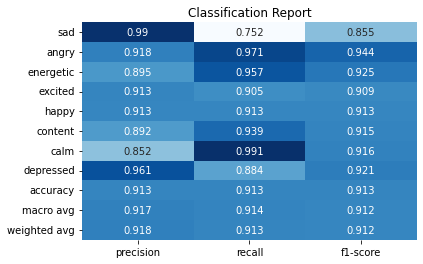

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report
#report = classification_report(y_test, y_pred_, target_names=categories, output_dict=True, digits=3)

# Convert report to a DataFrame
df = pd.DataFrame(result).transpose()

# Plot heatmap without science notation and in a bigger size than default.
#plt.figure(figsize=(10, 10))

sns.heatmap(df.iloc[:, :-1].astype(float), annot=True, cmap='Blues', fmt='.3g', cbar=False)
plt.title('Classification Report')

plt.show()


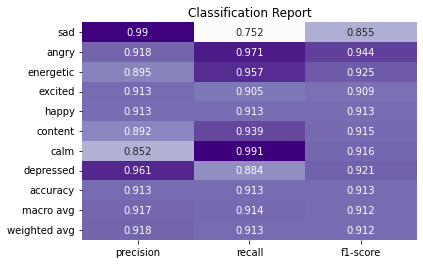

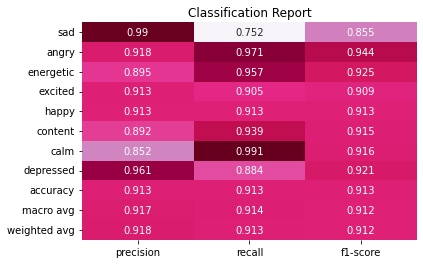

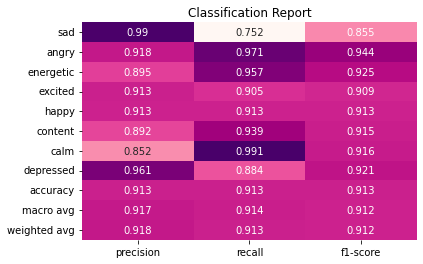

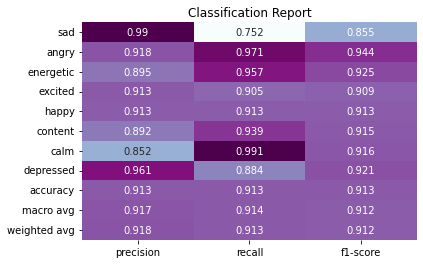

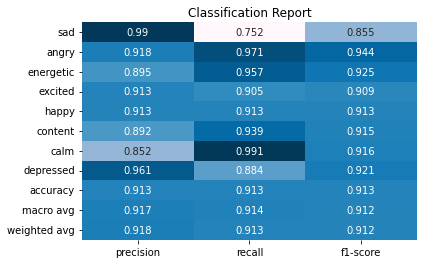

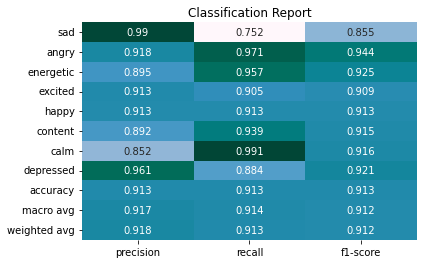

In [239]:
cmaps = ['Purples', 'PuRd','RdPu','BuPu','PuBu','PuBuGn']
for cmap in cmaps:
    sns.heatmap(df.iloc[:, :-1].astype(float), annot=True, cmap=cmap, fmt='.3g', cbar=False)
    plt.title('Classification Report')
    plt.show()

# testing on v5 dataset (skip)
only classes that do bad are the ones with small samples

In [29]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Audio Features/emotion joint data')
emotionsDF2 = pd.read_csv('Merged Emotions Data5.csv')
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v2.1')

In [30]:
#drop all the songs in balancedDF from emotionsDF2
emotionsDF2 = emotionsDF2[~emotionsDF2.index.isin(balancedDF.index)]

In [31]:
categories = ['sad', 'angry', 'energetic', 'excited', 'happy', 'content','calm',  'depressed']
emotionsDF2['mood'] = pd.Categorical(emotionsDF2['mood'], categories=categories, ordered=True)


In [32]:
X_test_v2 = emotionsDF2.drop(['uri','song','mood','genre'], axis=1)
X_test_v2 = clipAndNormalize(X_test_v2)
y_test_v2 = emotionsDF2['mood'].cat.codes

y_pred_v2 = rf2.predict(X_test_v2)
offByOne(y_test_v2, y_pred_v2)

              precision    recall  f1-score   support

           0      0.652     0.548     0.596       445
           1      0.174     0.904     0.292        94
           2      0.050     0.971     0.095        35
           3      0.111     0.904     0.197        73
           4      0.085     0.652     0.150        23
           5      0.245     0.419     0.309       172
           6      0.993     0.738     0.847       618
           7      0.987     0.486     0.651      3178

    accuracy                          0.542      4638
   macro avg      0.412     0.703     0.392      4638
weighted avg      0.886     0.542     0.638      4638

